In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
import itertools
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
import IPython
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Load and look at Data

In [8]:
rideguys = pd.read_csv('data/churn.csv')
rideguystrain = pd.read_csv('data/churn_train.csv')

In [7]:
rideguys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [56]:
rideguystrain.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.0,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.0,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.0,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0


# Update Datetime columns and add Churn

In [14]:
rideguys['last_trip_date'] = rideguys['last_trip_date'].apply(pd.to_datetime)

In [36]:
rideguys['signup_date'] = rideguys['signup_date'].apply(pd.to_datetime)

In [49]:
date = '06-01-2014'

In [52]:
rideguys['churn'] = (rideguys.last_trip_date < date)*1


In [46]:
churnmask = rideguys.loc[rideguys['last_trip_date'] > '05-31-2014']

# Random Forest model

In [67]:
rideguys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
churn                     50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [68]:
rideguys.dropna(subset = ["avg_rating_by_driver"], inplace=True)
rideguys.dropna(subset = ["avg_rating_of_driver"], inplace=True)
rideguys.dropna(subset = ["phone"], inplace=True)

In [69]:
X = rideguys[['avg_dist', 
     'avg_rating_by_driver', 
     'avg_rating_of_driver', 
     'avg_surge', 'surge_pct', 
     'trips_in_first_30_days', 
     'weekday_pct']].values
y = rideguys.churn.values

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.20,
                                                    random_state=111)



In [73]:
clf = DecisionTreeClassifier()
bootstrap_sample = np.random.choice(range(len(X_train)),
                                    len(X_train),
                                    replace=True)
clf.fit(X_train, y_train)

print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))
print(f"log loss = {-clf.score(X_test, y_test)}")

Accuracy = 0.657
log loss = -0.6570153215104355


In [74]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

log loss = 0.7466655371761431
accuracy = 0.7039449873326095


# Feature importance via Mean Decrease in Impurity/Accuracy

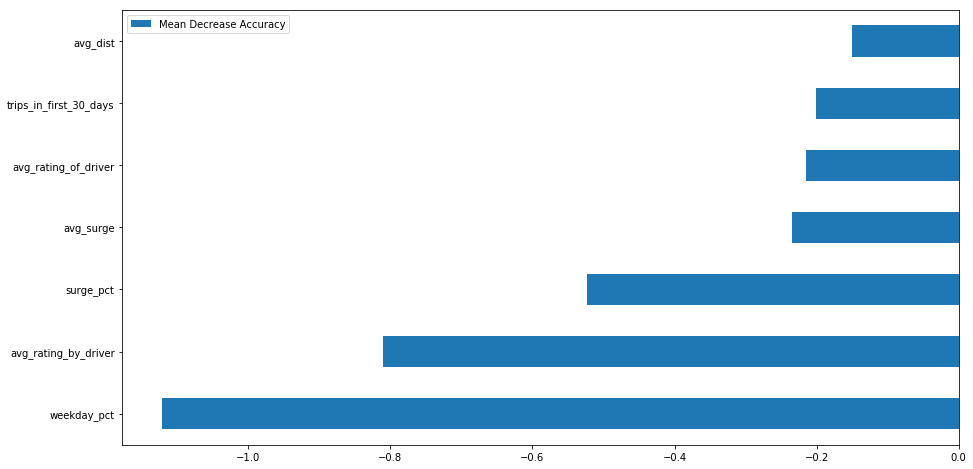

In [88]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

rf = RandomForestClassifier()
scores = defaultdict(list)


names = ['avg_dist', 
     'avg_rating_by_driver', 
     'avg_rating_of_driver', 
     'avg_surge', 'surge_pct', 
     'trips_in_first_30_days', 
     'weekday_pct']
 

scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(30, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize=(15,8))

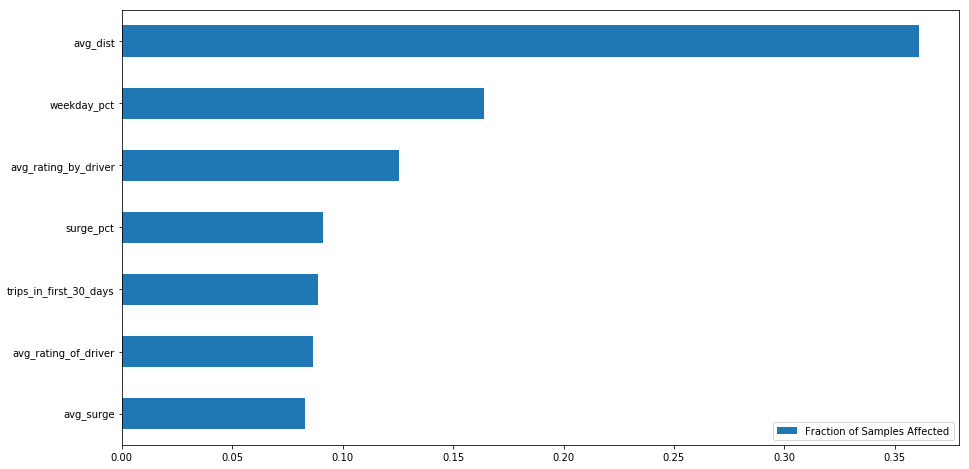

In [86]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=['avg_dist', 
     'avg_rating_by_driver', 
     'avg_rating_of_driver', 
     'avg_surge', 'surge_pct', 
     'trips_in_first_30_days', 
     'weekday_pct'])
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(15,8));

# Feature Selection via Forward Selection

In [81]:
import statsmodels.api as sm
class ForwardSelect(object):
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.best_score = 0.
        self.column_names = []
        self.keep = []
        self.X_orig = None
        self.X = None
        self.y = None

    def fit_transform(self, df, target):
        self.y = target
        self.column_names = df.columns.tolist()
        self.X_orig = df.values
        self.X = np.ones([self.X_orig.shape[0],1])
        
        while self.X_orig.shape[1] > 0:
            scores = []
            for feature in range(self.X_orig.shape[1]):
                X_temp = np.concatenate((self.X, self.X_orig[:, feature, None]), axis=1)
                scores.append(sm.OLS(self.y, X_temp).fit().rsquared_adj)
            best_idx = np.argmax(np.asanyarray(scores))

            if scores[best_idx] <= self.best_score:
                if self.verbose: 
                    print('Removed columns ->', self.column_names)
                    print('-> All done!')
                return self.X[:,1:]
            else:
                self.X = np.concatenate((self.X, self.X_orig[:, best_idx, None]), axis=1)
                self.X_orig = np.delete(self.X_orig, best_idx, axis=1)
                self.keep.append(self.column_names.pop(best_idx))
                self.best_score = scores[best_idx]
                if self.verbose: print('Kept \'%s\' for a best score of %s' % (self.keep[-1], self.best_score))

In [82]:
df = pd.DataFrame(X)
forward = ForwardSelect(verbose=True)
forward.fit_transform(df, y)

Kept '5' for a best score of 0.03950451239112529
Kept '0' for a best score of 0.043444812370244223
Kept '1' for a best score of 0.04385487995698245
Kept '3' for a best score of 0.04391685050335514
Kept '4' for a best score of 0.044221161022164224
Kept '6' for a best score of 0.04425317498011938
Kept '2' for a best score of 0.0442620542611456


In [90]:
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (np.log((1 - threshold)/threshold) - b0 - x*b1 )/b2

def plot_decision_boundary(X, y, model, ax=None):
    '''plot 2-d array of points, with decision boundaries'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=3)
    ax.plot(*X[y==0].mean(axis=0).reshape(-1,1), color='b', marker='+', mew=4, ms=20)
    ax.plot(*X[y==1].mean(axis=0).reshape(-1,1), color='g', marker='+', mew=4, ms=20)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    print (beta0, beta1, beta2)
    
    for threshold, ls in zip(1/(1+np.exp(-np.arange(-3,4))), [':', '-.', '--', '-', '--', '-.', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color='r',
                ls=ls,
                label="{:.2f}%".format(threshold*100))
    ax.legend(title='threshold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

In [105]:
citydum = pd.get_dummies(rideguys['city'], drop_first=True)

In [94]:
rideguys.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct', 'churn'],
      dtype='object')

In [108]:
phonedum = pd.get_dummies(rideguys['phone'], drop_first=True)

In [115]:
ridecity = pd.concat([rideguys, citydum], axis=1, sort=False)

In [116]:
ridecityphone = pd.concat([ridecity, phonedum], axis=1, sort=False)

In [118]:
ridecityphone.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct', 'churn',
       'King's Landing', 'Winterfell', 'iPhone'],
      dtype='object')

In [120]:
ridecityphone = ridecityphone[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'last_trip_date', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
       'King\'s Landing', 'Winterfell', 'iPhone', 'churn']]

In [123]:
ridecityphone = ridecityphone.reset_index()

In [129]:
ridecityphone = ridecityphone.drop(['index'], axis=1)


In [136]:
ridecityphone.head(20)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,King's Landing,Winterfell,iPhone,churn
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0,1
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,0,1,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,1,0,1
5,10.56,5.0,3.5,1.00,2014-06-06,2014-01-09,0.0,2,True,100.0,0,1,1,0
6,2.04,5.0,5.0,1.00,2014-01-29,2014-01-28,0.0,2,False,100.0,0,1,1,1
7,4.36,5.0,4.5,1.00,2014-02-01,2014-01-21,0.0,2,False,100.0,0,1,0,1
8,4.28,4.9,5.0,1.00,2014-05-30,2014-01-13,0.0,1,True,100.0,0,1,1,1
9,3.81,5.0,4.0,1.00,2014-01-10,2014-01-06,0.0,3,False,100.0,0,1,1,1


In [134]:
ridecityphone['weekday_pct'].unique()

array([ 46.2,  50. , 100. ,  80. ,  82.4,  95.2,  80.8,  66.7,  36.4,
        25. ,  40. ,  61.6,   0. ,  71.4,  52.4,  22.2,  75. ,  54.1,
        63.2,  84. ,  81.8,  67.6,  42.9,  55.2,  76.9,  90. ,  89.7,
        33.3,  63.6,  85.7,  88.9,  41.2,  20. ,  37.5,  43.8,  45.5,
        16.7,  41.7,  10. ,  57.5,  57.7,  28.6,  62.9,  30. ,  69. ,
        62.5,  83.8,  57.1,  52.2,  72.2,  39.1,  46.3,  87.5,  83.3,
        44.4,  55.6,  69.2,  14.3,  76.5,  78.6,  88.3,  56.7,  70.9,
        60. ,  23.1,  65.2,  93.1,  64. ,  61.5,  12.5,   7.1,  79.2,
        54.8,  31. ,  92.9,  56.1,  46.7,  94.4,  91.9,  84.2,  71.1,
        61.9,  70. ,  70.6,  21.4,  92.6,   7.7,  58.3,  77.8,  74.3,
        47.4,  84.6,  56.5,  47.8,  60.7,  31.3,  77.1,  90.9,  81.3,
        88.2,  82.5,  53.3,  71.6,  49.3,  54.2,  91.7,  84.9,  54.5,
        73.3,  68.9,  76.4,  78. ,  55. ,  42.1,  23.5,  57.4,  69.8,
        70.4,  69.3,  31.4,  90.5,  75.8,  73.4,  72.7,  64.3,  72.4,
        78.9,  59.5,

# great denominator fishing expidition

In [141]:
from fractions import Fraction

In [137]:
def gcd(a, b): 
      
    if (a == 0): 
        return b 
    return gcd(b % a, a) 
  
  
# function to calculate 
# lcm of two numbers. 
def lcm(a, b): 
      
    return (a * b) / gcd(a, b) 

In [139]:
x = 0.4
y = 0.3

denominators = range(1,1000)

def find_common_demon(x, y):
    denominators = range(1,2000)
    x_good_denoms = []
    y_good_denoms = []
    for d in denominators:
        rounded = np.round(x, 3)
        if 1/d == rounded:
            x_good_denoms.append(d)
           
    for d in denominators:
        if y * d == np.floor(y*d ):
            y_good_denoms.append(d)
   
       
    x_denom = min(x_good_denoms)
    y_demon = min(y_good_denoms) 


In [152]:
x = str(Fraction(0.25))

In [157]:
x.split('/').pop()

'4'

In [159]:
ridecityphone['trips_in_first_30_days'].mean()

2.609675473519122

In [160]:
ridecityphone.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,King's Landing,Winterfell,iPhone,churn
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0,1
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,0,1,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,1,0,1


In [173]:
ridecityphone['customer_value'] = (1 - ridecityphone['trips_in_first_30_days']*(ridecityphone['surge_pct_pct'])*0.75 + ridecityphone['trips_in_first_30_days']*(ridecityphone['surge_pct_pct'])*1 

SyntaxError: unexpected EOF while parsing (<ipython-input-173-3ab6e44fc46e>, line 1)

In [171]:
ridecityphone['surge_pct_pct'] = ridecityphone['surge_pct']/100

In [177]:
ridecityphone['customer_value'] = (((1 - (ridecityphone['trips_in_first_30_days']*(ridecityphone['surge_pct_pct']))*0.75) 
                                   + (ridecityphone['trips_in_first_30_days']*(ridecityphone['surge_pct_pct'])*1))

SyntaxError: unexpected EOF while parsing (<ipython-input-177-8c7f5cf08f0c>, line 2)

In [182]:
ridecityphone['surge_value'] = ridecityphone['trips_in_first_30_days']*(ridecityphone['surge_pct_pct'])*1
ridecityphone['non_surge_value'] = (ridecityphone['trips_in_first_30_days']*(1-(ridecityphone['surge_pct_pct'])))*0.75 

In [183]:
ridecityphone['customer_value'] = ridecityphone['surge_value'] + ridecityphone['non_surge_value']


In [184]:
ridecityphone

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,King's Landing,Winterfell,iPhone,churn,customer_value,surge_pct_pct,surge_value,non_surge_value
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,1,0,3.15400,0.154,0.616,2.53800
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0,1,0.00000,0.000,0.000,0.00000
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,0,1,1,2.25000,0.000,0.000,2.25000
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,1,0,7.20000,0.200,1.800,5.40000
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,1,0,1,10.91300,0.118,1.652,9.26100
5,10.56,5.0,3.5,1.00,2014-06-06,2014-01-09,0.0,2,True,100.0,0,1,1,0,1.50000,0.000,0.000,1.50000
6,2.04,5.0,5.0,1.00,2014-01-29,2014-01-28,0.0,2,False,100.0,0,1,1,1,1.50000,0.000,0.000,1.50000
7,4.36,5.0,4.5,1.00,2014-02-01,2014-01-21,0.0,2,False,100.0,0,1,0,1,1.50000,0.000,0.000,1.50000
8,4.28,4.9,5.0,1.00,2014-05-30,2014-01-13,0.0,1,True,100.0,0,1,1,1,0.75000,0.000,0.000,0.75000
9,3.81,5.0,4.0,1.00,2014-01-10,2014-01-06,0.0,3,False,100.0,0,1,1,1,2.25000,0.000,0.000,2.25000
